In [1]:
import os
import shap
import json

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


# <u>Tentative de modelisation et prédiction de la variable : Intensité d'emission de GES</u>

## <u>1 : Modelisations en prenant en compte la note Energy Star (E*)</u>
### <u>1.1 : Regressions lineaires</u>

## <u>2 : Etude de l'importance de la note Energy Star</u>
### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>
### <u>2.2 : Utilisation de la certification plutot que le score</u>


## <u>1 : Modelisations prenant en compte toutes les variables retenues lors de l'étude</u>
### <u>1.1 : Regressions lineaires</u>

#### 1.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire (breakpoint = export 1)
    -  Note : Donnees inutilisables, oublie d'export de la variable cible
- Un split satisfaisant a deja été trouvé et fixé, ces données viendront sur-ecrire le split proposé par le modele
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out

In [2]:
general_file = "./data/seattle_predict_ghg_eui.csv"  # Used as backup


In [3]:
df_ghg = pd.read_csv(general_file)
df_ghg.set_index("OSEBuildingID", inplace=True)


In [4]:
df_ghg.head()


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_ptype_Mixed Use Property,ohe_ptype_Office,ohe_ptype_Other,ohe_ptype_Refrigerated Warehouse,ohe_ptype_Residence Hall,ohe_ptype_Small & Medium medical facility,ohe_ptype_Small & Mid-Sized Office,ohe_ptype_Supermarket & Grocery store,ohe_ptype_Warehouse,ohe_ptype_Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,1927,1,12,60.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.615322,1.799564,0.659821,0.913481,4.178122,1996,1,11,61.0,0.855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.380423,3.572830,-0.095878,1.536320,1.009034,1926,1,10,56.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.401384,1.074583,0.292078,0.455283,2.089235,1926,1,11,27.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.326328,3.945117,-0.029889,0.564008,2.706276,1928,1,9,48.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_ghg.columns


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_nbhood_BALLARD',
       'ohe_nbhood_CENTRAL', 'ohe_nbhood_DELRIDGE', 'ohe_nbhood_DOWNTOWN',
       'ohe_nbhood_EAST', 'ohe_nbhood_GREATER DUWAMISH',
       'ohe_nbhood_LAKE UNION', 'ohe_nbhood_MAGNOLIA / QUEEN ANNE',
       'ohe_nbhood_NORTH', 'ohe_nbhood_NORTHEAST', 'ohe_nbhood_NORTHWEST',
       'ohe_nbhood_SOUTHEAST', 'ohe_nbhood_SOUTHWEST', 'ohe_ptype_Hospital',
       'ohe_ptype_Hotel', 'ohe_ptype_K-12 School', 'ohe_ptype_Large Office',
       'ohe_ptype_Mixed Use Property', 'ohe_ptype_Office', 'ohe_ptype_Other',
       'ohe_ptype_Refrigerated Warehouse', 'ohe_ptype_Residence Hall',
    

In [6]:
# Target : target_GHGEmissionsIntensity(kgCO2e/ft2) :

droplist = [
    "scaled_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "target_SourceEUI(kWh/m2)",  # not to scale
    ]

df_model = df_ghg.drop(columns=droplist)


In [7]:
ghg_target = "target_GHGEmissionsIntensity(kgCO2e/ft2)"
ghg_regression = Linear_reg(dataframe=df_model, target=ghg_target)


In [8]:
# Loading known split, ids are unique building OSE id

with open("./data/splits_ghg.json", "r") as json_file:
    splits = json.load(json_file)

ids_train = splits["train"]
ids_test = splits["test"]


In [9]:
# Overriding

df_train_override = df_model[df_model.index.isin(ids_train)]
df_test_override = df_model[df_model.index.isin(ids_test)]

ghg_regression.force_split(
    df_train_ovr=df_train_override,
    df_test_ovr=df_test_override
)


#### Execution : 
Parametres : 
- Ridge = 0.1, 45, step 0.05
- Elastic Net = Alpha = Alpha_ridge = 0.1, 45, step 0.05, default L1 ratio
- Lasso Alpha = 0.01, 15, 0.04

In [10]:
# Recheck default : 
ghg_regression.common_parameters["cv"] = None
#

alphas_ridge = np.arange(0.1, 45, 0.05)
alphas_elnet = alphas_ridge
alphas_lasso = np.arange(0.01, 15, 0.04)

ghg_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)



##### --> 1 Visualisation des alphas et leur pertinence, affichage des meilleurs hyperparametres
##### --> 2 Comparaison des metriques

In [11]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.20000000000000004
Time used during fit = 7.387670583999977
Time used during predict = 0.0018300829999589041


Ridge: 

Ridge best Alpha : 7.600000000000002
Time used during fit = 0.22506162500002347
Time used during predict = 8.604200002082507e-05


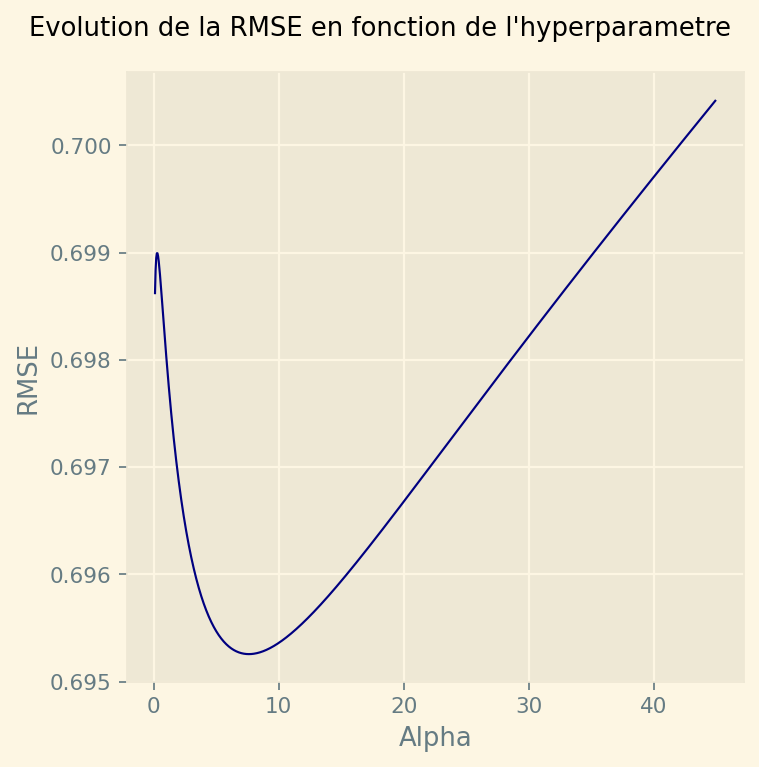

In [12]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")

ghg_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.05
Time used during fit = 0.19032433300003504
Time used during predict = 0.00012970799997447102


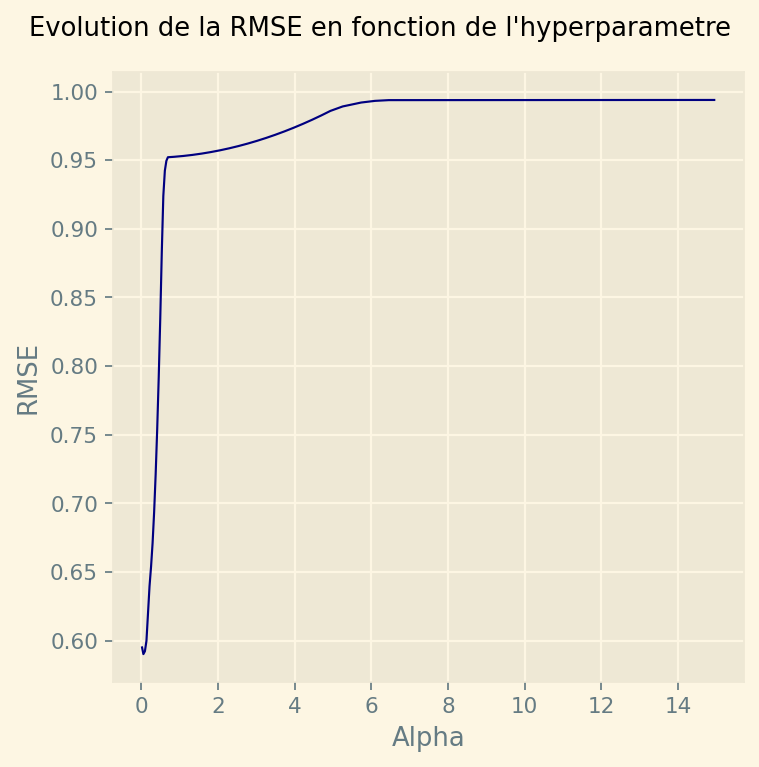

In [13]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")

ghg_regression.lasso_plot()


In [14]:
metrics_with_estar_l1out = ghg_regression.format_all_metrics()

df_predictions_estar_l1out = ghg_regression.df_predictions

metrics_with_estar_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.775195,0.304334,0.695258,0.605445,0.768239,0.53131,0.952816,0.546543
Test,0.690249,0.59779,0.686365,0.602304,0.741084,0.536366,0.737451,0.5409
Test/Train,0.89,1.964,0.987,0.995,0.965,1.01,0.774,0.99


In [15]:
# Saving Ridge Model and its predictions : 

ridge_l1out_estar = ghg_regression.ridge_cv
predictions_ridge_l1out_estar = ghg_regression.df_predictions["Ridge"]


##### Observation 1.1.a : 
- Ridge semble etre le plus prometteur dans ce cas avec un score R2 superieur a .6 et une transition train --> test stable.
- L'erreur est de .695 et .686 kg de CO2/m2 pour les donnees train/test, respectivement. Le plus bas de toutes les regressions
- On suit particulierement ridge lors du passage a la verification via Kfolds

In [16]:
# freeze_model(model=ghg_regression, save_file=True, file_path="./data/ghg_splits.json")
# uncomment to save train test split ids (OSEBuildingID)


#### 1.1.b : Cross validation = RepeatedKfold
- Memes parametres que 1.1.a
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : RepeatedKfold(30 fois : 10 splits, 3 executions)
- On attend des temps de traitement nettement superieurs

In [17]:
k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ghg_regression.common_parameters["cv"] = k_folds


In [18]:
# Re executing all with adjusted cross validation parameters :

# alphas_ridge = np.arange(0.1, 45, 0.05)  <-- already assigned, commented as a reminder
# alphas_elnet = alphas_ridge
# alphas_lasso = np.arange(0.01, 15, 0.04)

ghg_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)



In [19]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.1
Time used during fit = 44.50900337500002
Time used during predict = 0.001192124999988664


In [20]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 12.900000000000004
Time used during fit = 25.16523562499998
Time used during predict = 0.00027649999998402564


In [21]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 1.0698956670000257
Time used during predict = 0.0013115830000174356


In [22]:
metrics_with_estar_rkfold = ghg_regression.format_all_metrics()

df_predictions_estar_rkfold = ghg_regression.df_predictions

print("Kfold (10*3) : \n")

metrics_with_estar_rkfold


Kfold (10*3) : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.701364,0.477645,0.698721,0.600909,0.705762,0.579547,0.948466,0.571798
Test,0.690249,0.59779,0.690054,0.598017,0.715056,0.568361,0.716052,0.567157
Test/Train,0.984,1.252,0.988,0.995,1.013,0.981,0.755,0.992


In [23]:
print("Leave One Out : \n")

metrics_with_estar_l1out


Leave One Out : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.775195,0.304334,0.695258,0.605445,0.768239,0.53131,0.952816,0.546543
Test,0.690249,0.59779,0.686365,0.602304,0.741084,0.536366,0.737451,0.5409
Test/Train,0.89,1.964,0.987,0.995,0.965,1.01,0.774,0.99


##### Observations :
- Etonnament, la validation croisee avec les parametres utilisés (10 folds répétés 3 fois) n'offre pas de gain dans le cas de Ridge, au contraire
- Les autres modeles de regression sont toujours moins performants, que ce soit au niveau de l'erreur ou du score R2, ainsi que la transition train/test
- Ridge Leave One Out se montre, dans ce cas, le meilleur candidat pour modeliser l'intensité d'emissions de GES
- On utilise Ridge avec Leave One Out comme baseline.
- Le temps de traitement en utilisant la methode Leave One Out est egalement beaucoup plus rapide que RKfolds

In [24]:
# Reverting to cv = None for l1out

ghg_regression.common_parameters["cv"] = None


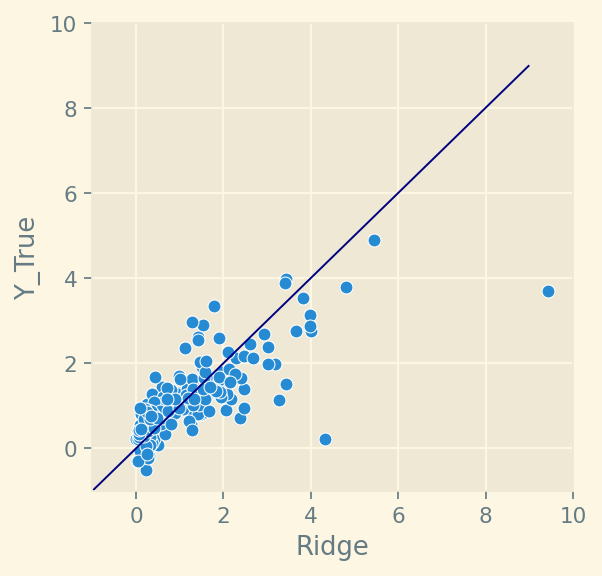

In [25]:
ghg_regression.use_ridge_cv(alphas=alphas_ridge)  # obj.df_predictions actualized and reset for shap

ghg_regression.scatter_true_pred(regression_name="Ridge")


#### Conclusion, partie 1 : 

- Ridge semble être le modèle à la fois le plus precis et le plus consistant. La validation via Kfolds n'offre pas d'avantages mais des pertes, que ce soit en terme de precision ou de temps.

## <u>2 : Etude de l'importance de la note Energy Star</u>

### <u>2.0 : Feature importance via SHAP</u>

In [26]:
X_all = ghg_regression.df_origin.drop(columns=[ghg_target]).to_numpy()
X100 = shap.utils.sample(X_all, 100) # 100 instances for use as the background distribution

features = ghg_regression.df_origin.drop(columns=[ghg_target]).columns

explainer = shap.LinearExplainer(ghg_regression.ridge_cv, X100, feature_names=features)
shap_values = explainer(X_all)


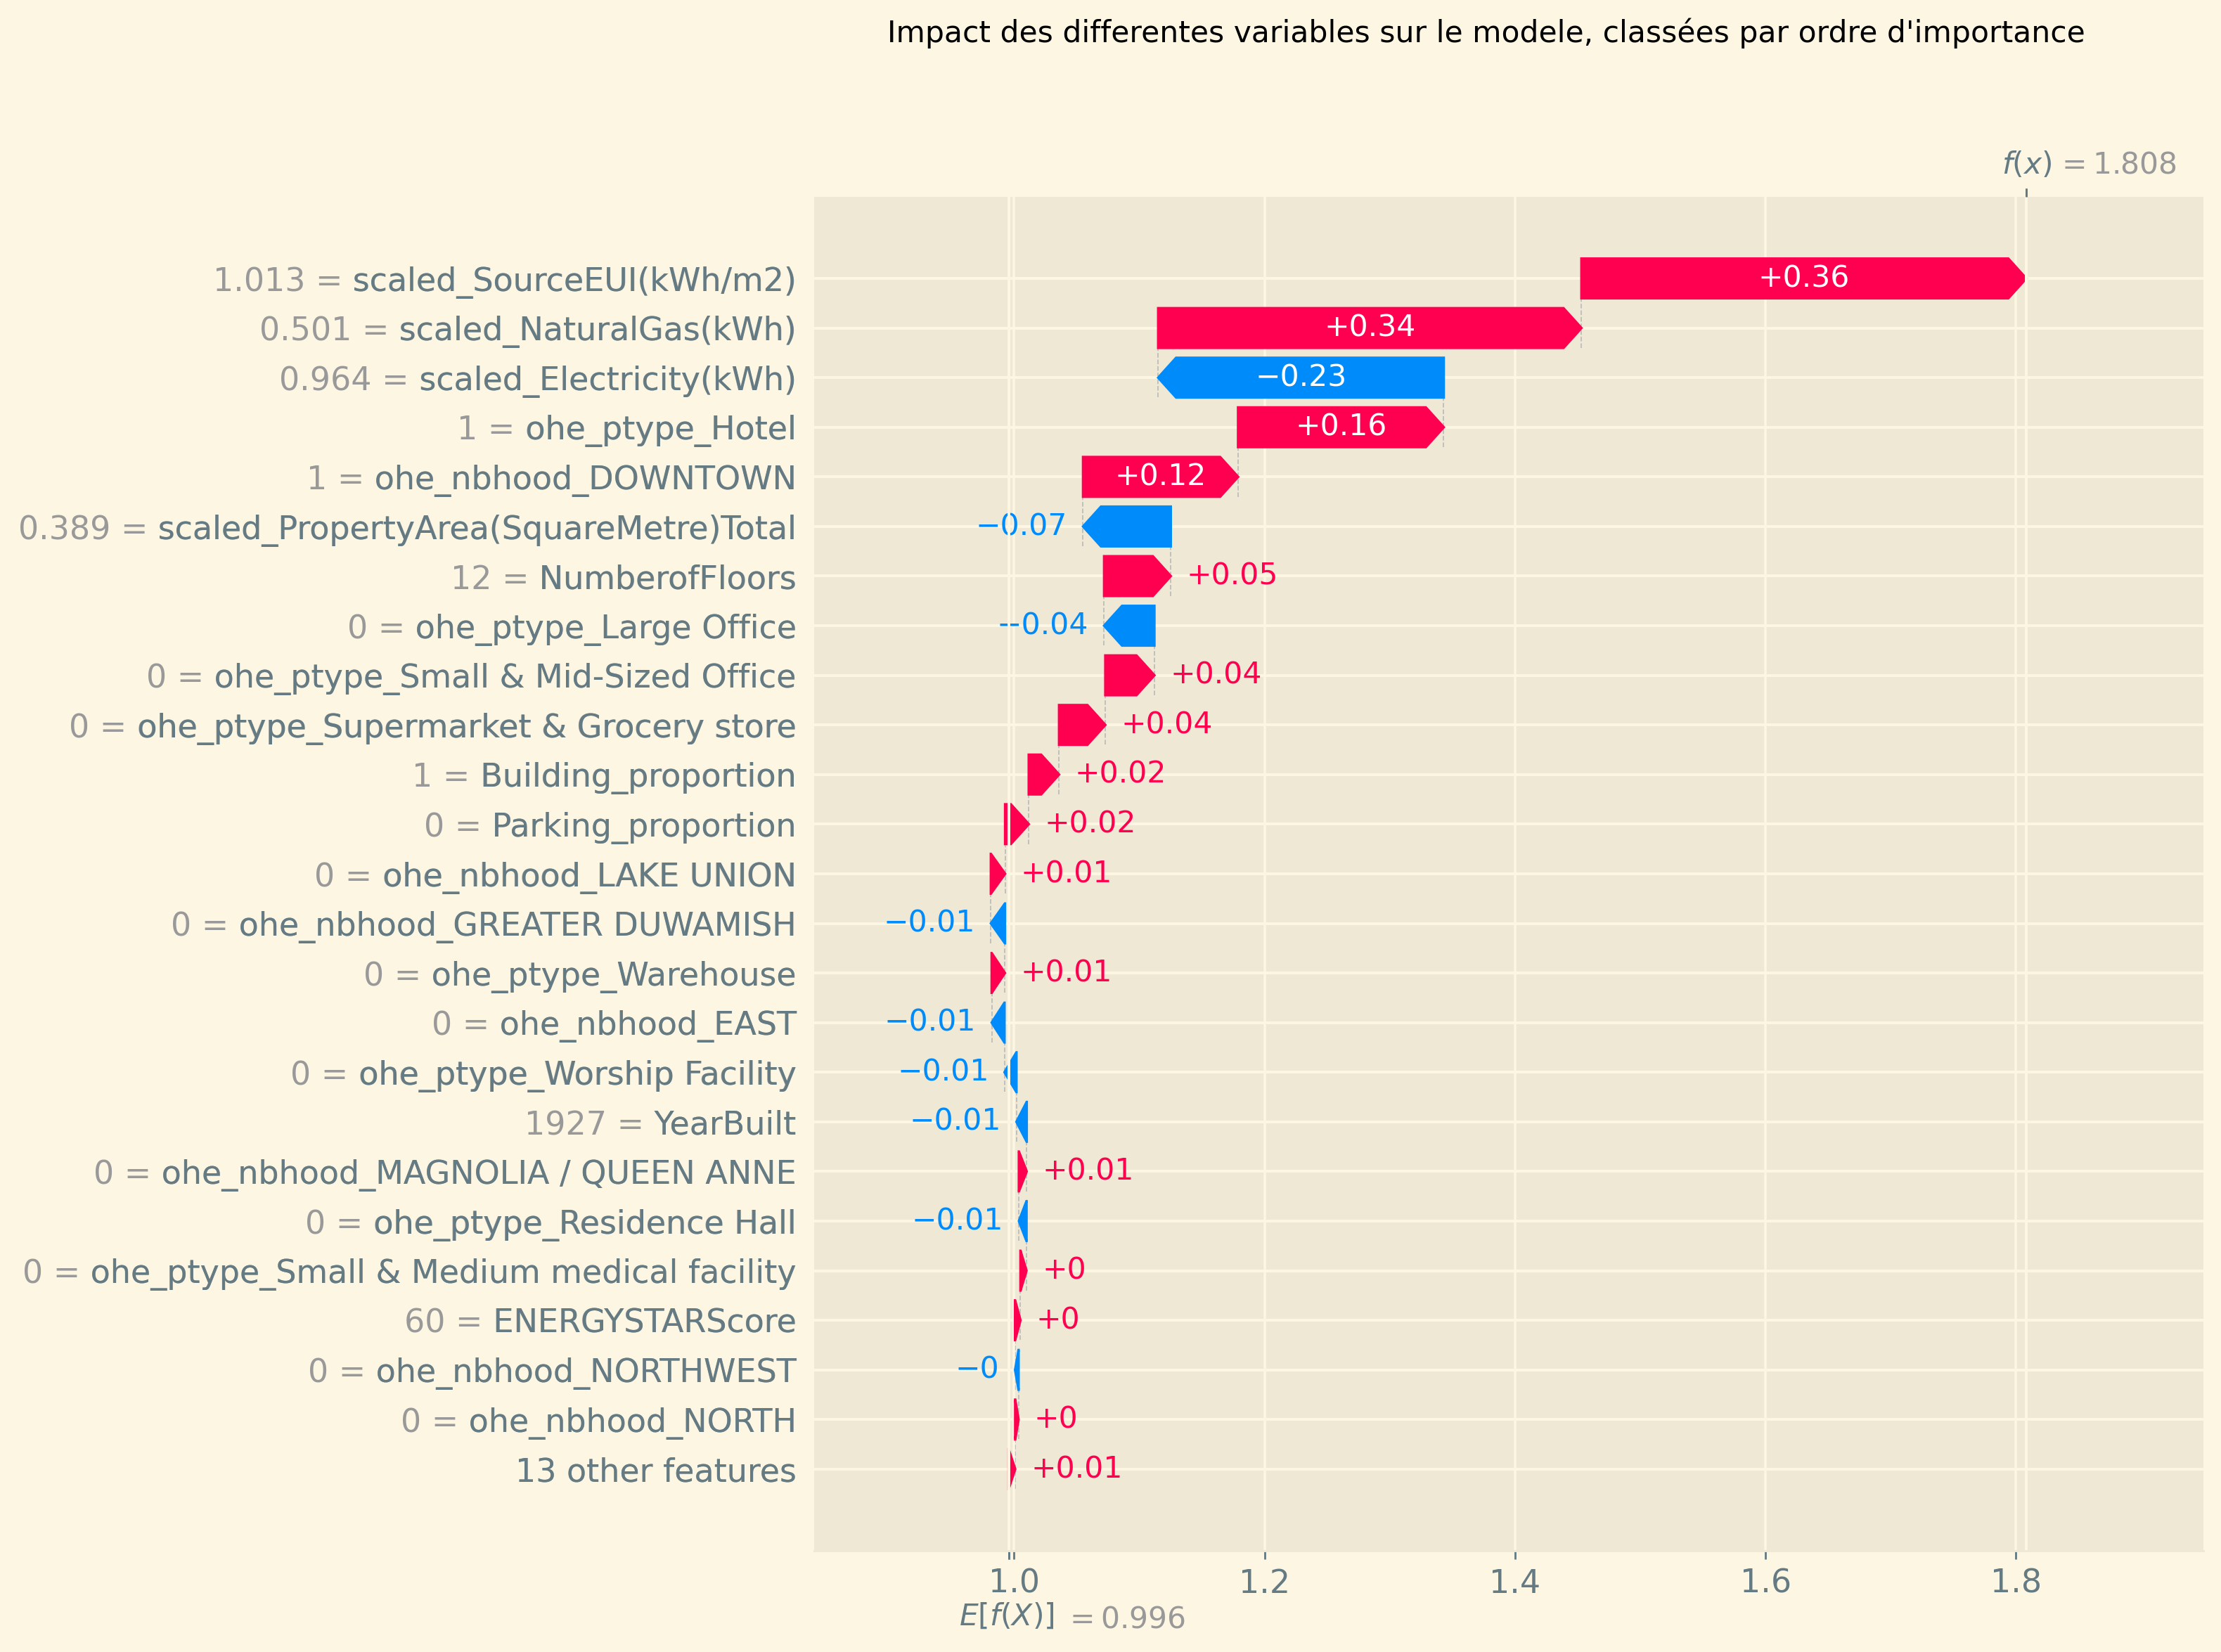

In [27]:
sample_ind = 18
my_waterfall = shap.plots.waterfall(shap_values[0], max_display=25, show=False)
my_waterfall.figure.set_size_inches(10, 10)
my_waterfall.figure.set_dpi(pc_dpi)

my_waterfall.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


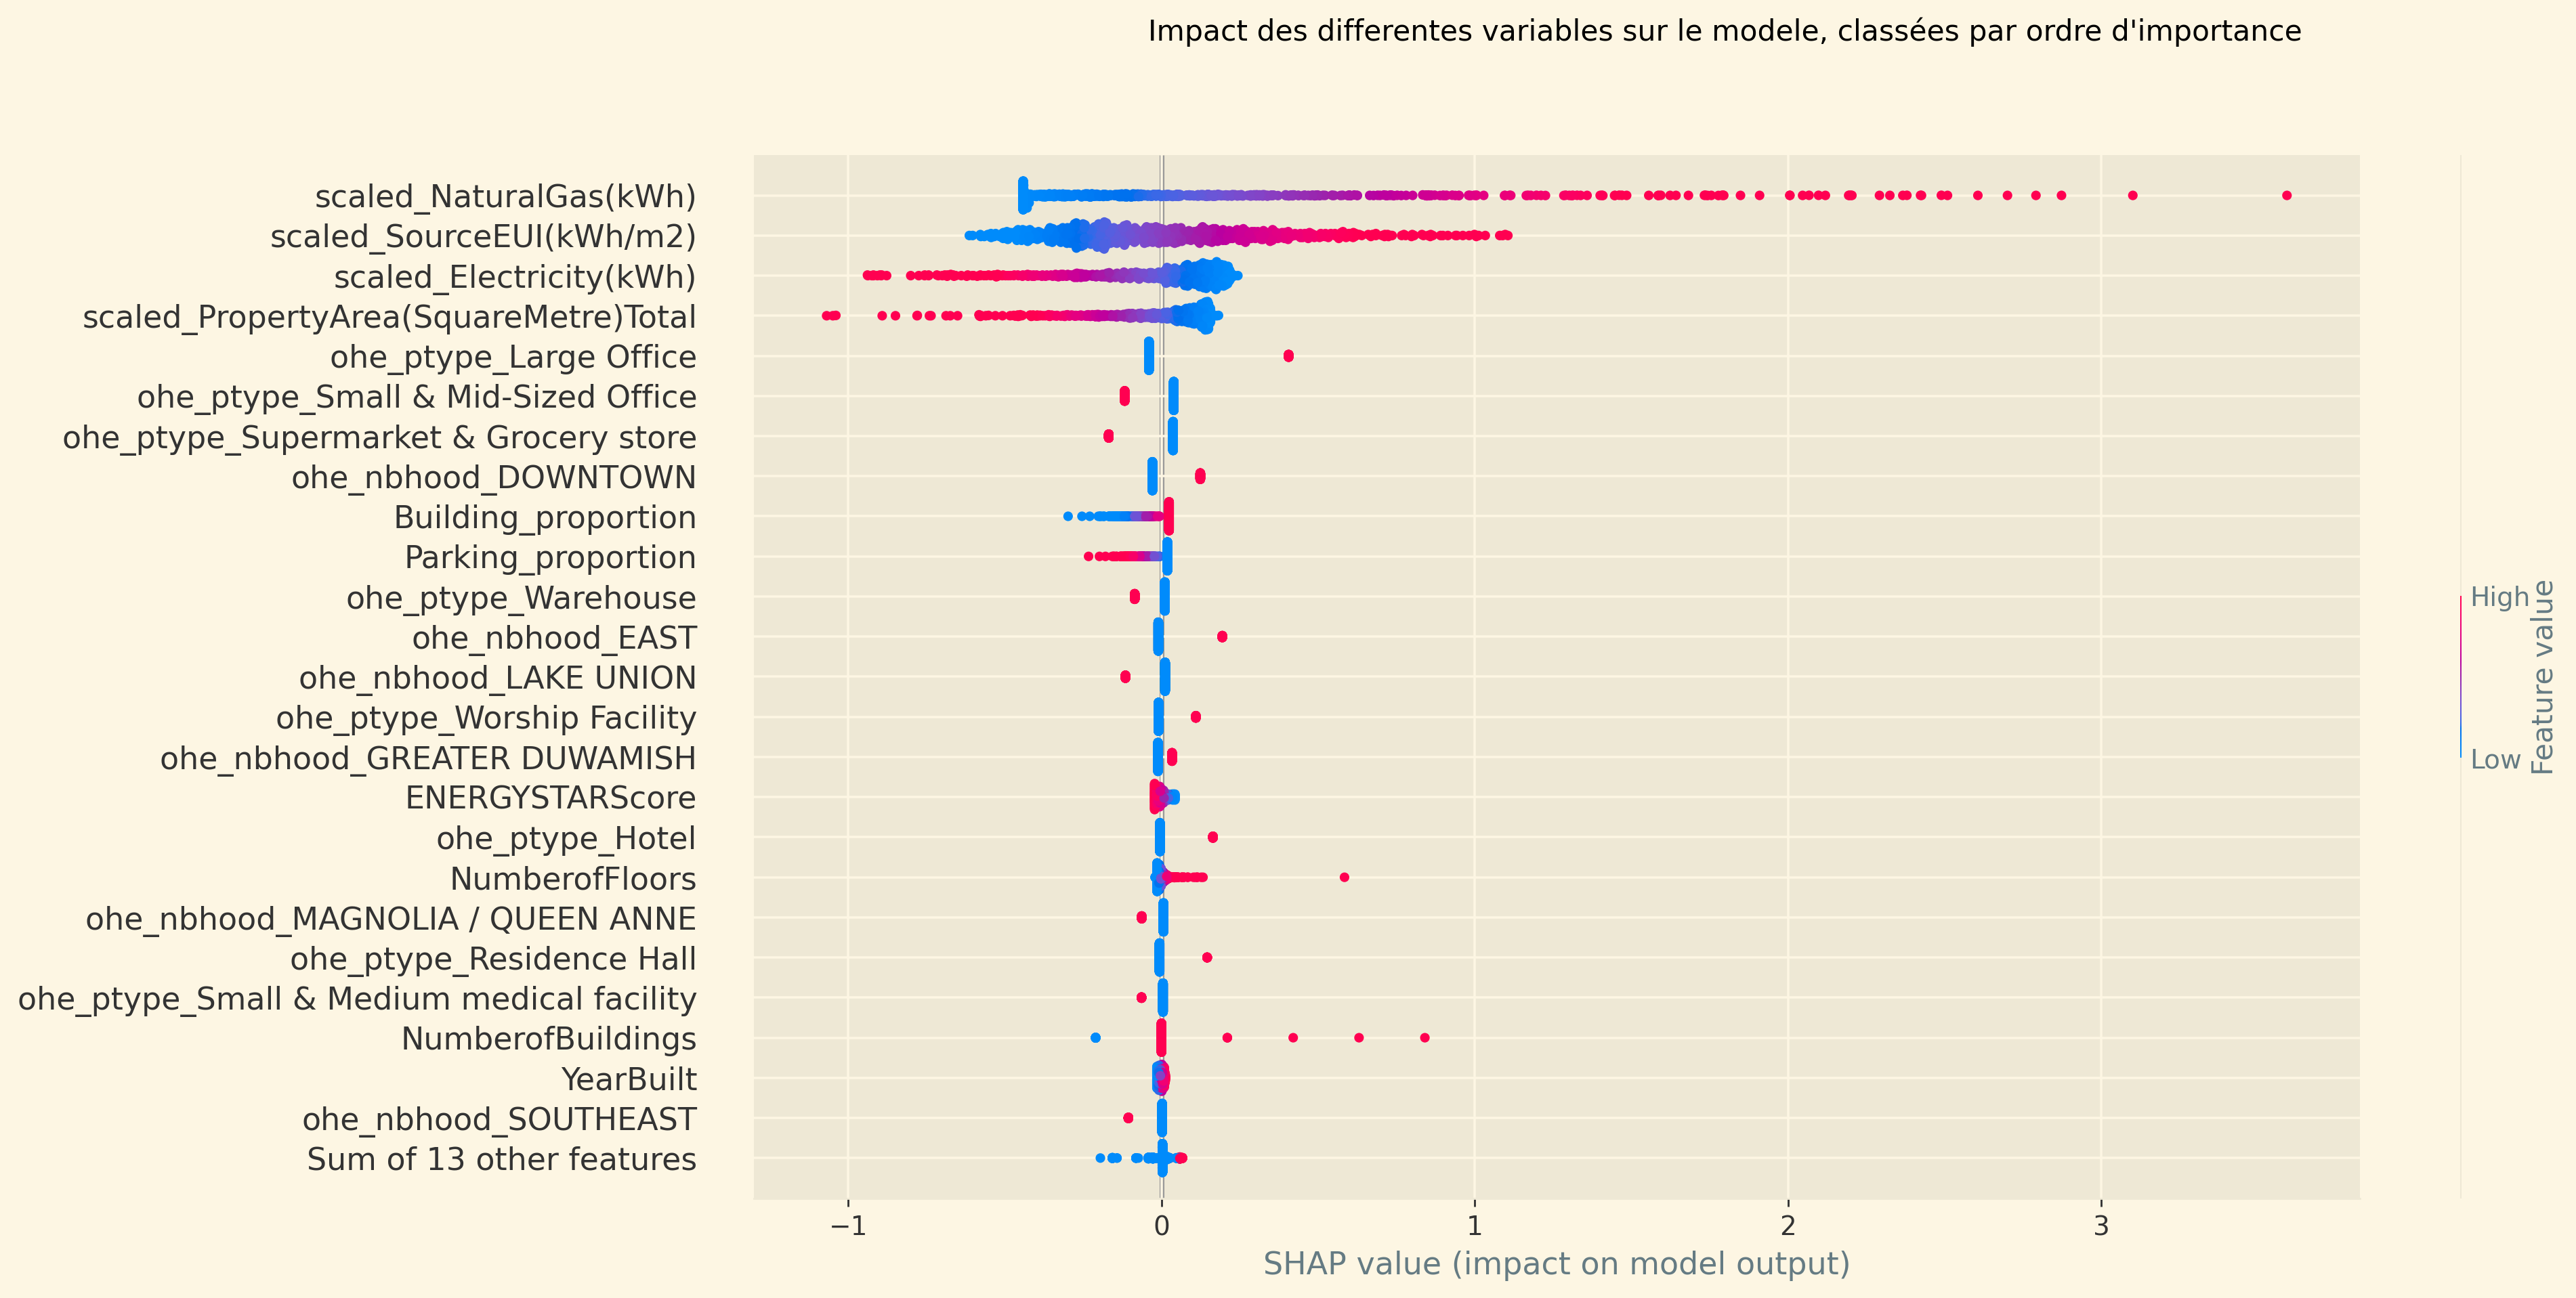

In [28]:
summary = shap.plots.beeswarm(shap_values, max_display=25, show=False)

summary.figure.set_size_inches(15, 8)
summary.figure.set_dpi(pc_dpi)

summary.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


#### Observations :

Dans le cas de la modelisation de l'intensité d'emission de GaES, l'impact du score ENERGY STAR ne semble pas avoir d'importance. En effet, les graphes ci dessus montrent que la variable influe extremement peu sur la sortie du modèle : <b>Waterfall n1 : idx = 22, < .01 || Summary n2 : idx = 17, impact extremement faible</b> <br>
Ici, on peut emettre l'hypothèse que ne pas utiliser E* n'appauvrirait que très peu nos modeles <br>
Le modele selectionné à l'issue de la premiere partie de cette analyse etait Ridge en utilisant un systeme de validation Leave One Out. <br>
On peut adapter la classe pour qu'elle abandonne le score E* et voir comment cela se traduit au niveau du modèle.

### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>

In [29]:
drop_estar = ["ENERGYSTARScore"]
ghg_regression.drop_col(col_list=drop_estar)


In [30]:
# checking ENERGYSTARScore not in matrices : shape should be 1 less than original dfs

if ghg_regression.X_test.shape[1] >= len(ghg_regression.df_train.columns) + 1:  # +1 because target still in cols
    print("Oops")
else:
    print("Ok")


Ok


#### 2.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire (breakpoint = export 1)
    -  Note : Donnees inutilisables, oublie d'export de la variable cible
- Un split satisfaisant a deja été trouvé et fixé, ces données viendront sur-ecrire le split proposé par le modele
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out
- Energy Star Score ne figure plus dans les matrices X_train, X_test
- Memes parametres initiaux que la regression comportant E*

#### Execution : 
Parametres : 
- Ridge = 0.1, 45, step 0.05
- Elastic Net = Alpha = Alpha_ridge = 0.1, 45, step 0.05, default L1 ratio
- Lasso Alpha = 0.01, 15, 0.04

In [31]:
ghg_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
    )


In [32]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.20000000000000004
Time used during fit = 7.076014291000035
Time used during predict = 8.629199999177217e-05


Ridge: 

Ridge best Alpha : 8.450000000000003
Time used during fit = 0.14533345800003872
Time used during predict = 7.57909999720141e-05


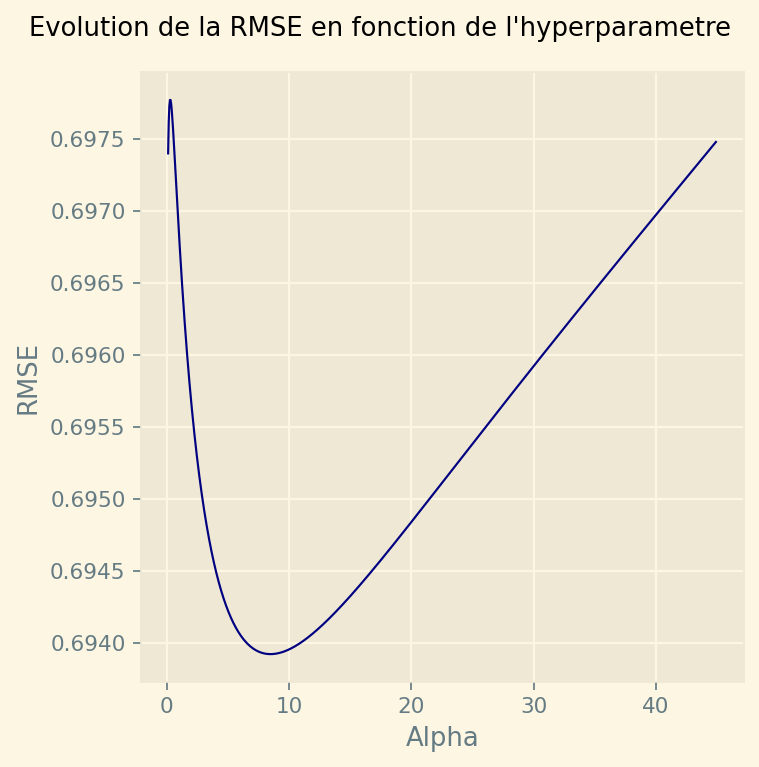

In [33]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")

ghg_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.09
Time used during fit = 0.17950995799998282
Time used during predict = 6.60829999787893e-05


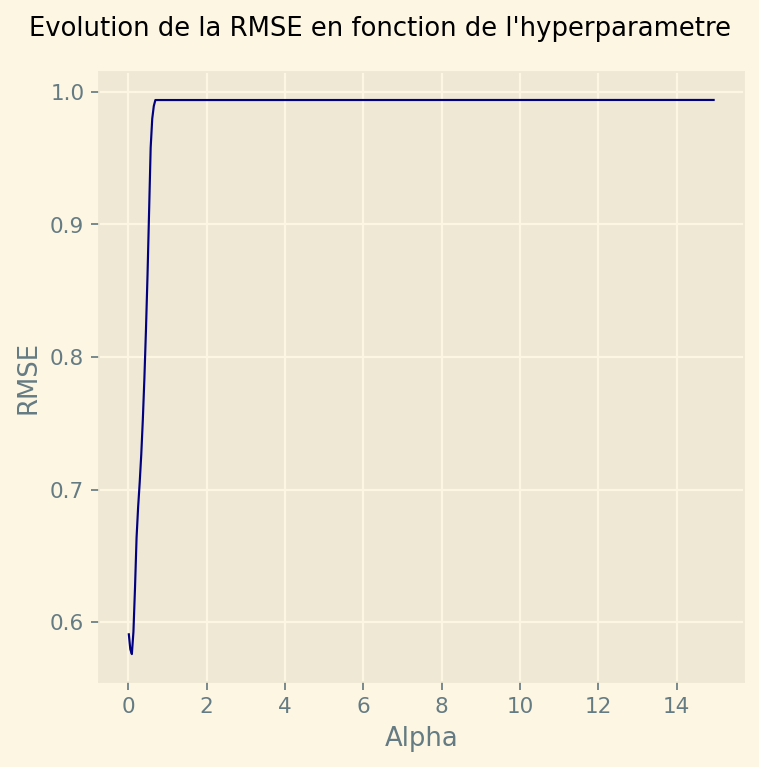

In [34]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")

ghg_regression.lasso_plot()


In [35]:
metrics_without_estar_l1out = ghg_regression.format_all_metrics()

df_predictions_no_estar_l1out = ghg_regression.df_predictions

metrics_without_estar_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.773787,0.307906,0.69392,0.60469,0.758823,0.511111,0.971722,0.547133
Test,0.69112,0.596775,0.688308,0.60005,0.762943,0.508612,0.741386,0.535988
Test/Train,0.893,1.938,0.992,0.992,1.005,0.995,0.763,0.98


#### 2.1.b : Cross validation = RepeatedKfold
- Memes parametres que 2.1.a
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : RepeatedKfold(30 fois : 10 splits, 3 executions)
- On attend des temps de traitement nettement superieurs

In [36]:
ghg_regression.common_parameters["cv"] = k_folds


In [37]:
ghg_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
    )


In [38]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.1
Time used during fit = 42.69273158300001
Time used during predict = 0.00030583299997033464


In [39]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 15.500000000000005
Time used during fit = 24.075342750000004
Time used during predict = 0.001761041000008845


In [40]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 1.0603025829999524
Time used during predict = 6.412499999441934e-05


In [41]:
print("Metrics using Leave One Out method, E* in model : \n")

metrics_with_estar_l1out


Metrics using Leave One Out method, E* in model : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.775195,0.304334,0.695258,0.605445,0.768239,0.53131,0.952816,0.546543
Test,0.690249,0.59779,0.686365,0.602304,0.741084,0.536366,0.737451,0.5409
Test/Train,0.89,1.964,0.987,0.995,0.965,1.01,0.774,0.99


In [42]:
metrics_without_estar_kfold = ghg_regression.format_all_metrics()

print("Metrics using repeated Kfold method (10, 3 repeats), E* not in model : \n")

metrics_without_estar_kfold


Metrics using repeated Kfold method (10, 3 repeats), E* not in model : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.699728,0.480616,0.700687,0.598903,0.701936,0.58002,0.967531,0.572198
Test,0.69112,0.596775,0.693591,0.593886,0.716632,0.566456,0.719025,0.563555
Test/Train,0.988,1.242,0.99,0.992,1.021,0.977,0.743,0.985


In [43]:
print("Metrics using Leave One Out method, E* in model : \n")

metrics_with_estar_l1out


Metrics using Leave One Out method, E* in model : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.775195,0.304334,0.695258,0.605445,0.768239,0.53131,0.952816,0.546543
Test,0.690249,0.59779,0.686365,0.602304,0.741084,0.536366,0.737451,0.5409
Test/Train,0.89,1.964,0.987,0.995,0.965,1.01,0.774,0.99


#### Observations :

L'hypothèse selon laquelle E* serait indispensable à la modelisation de predictions <u>concernant les emissions de GaES</u> semble fausse. Le modele Ridge est suffisamment robuste. L'analyse via SHAP et les comparaisons entre les differentes methodes nous montre que, via à vis de nos données, l'utilisation d'une regression Ridge est optimale. La note E* apporte trop peu au modèle pour etre consideree comme vitale. Les gains apportés ne valent pas les efforts demandés pour l'obtenir.

- Recommandations issues de l'étude : Ridge utilisant une methode de validation croisée "Leave One Out". Notre echantillon de données offre une precision acceptable (R2 >= .6) pour une étude approfondie, l'eventuel apport de nouvelles variables.
- Le modele s'est montré particulierement sensibles aux variables One Hot Encodées. On pourrait etendre ce modèle pour ameliorer sa precision en utilisant d'autres features categorielles (Materiaux de construction, entreprise contractée pour les travaux, date de modernisation etc.)